In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from astropy.table import Table

# === Load FITS file ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")

# === Convert to Pandas DataFrame ===
df = data.to_pandas()

# === Drop rows with any NaNs or masked values in selected columns ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])

# === Feature matrix and target ===
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# For demonstration purposes, mock example:
np.random.seed(42)
n_samples = 200
X = pd.DataFrame({
    "COLOR_G-R": np.random.normal(0.5, 0.1, n_samples),
    "DN4000": np.random.normal(1.5, 0.3, n_samples),
    "SFR": np.random.normal(0.1, 0.05, n_samples)
})
y = 0.3 * X["COLOR_G-R"] - 0.4 * X["DN4000"] + 0.2 * X["SFR"] + np.random.normal(0, 0.1, n_samples)

# === Define models ===
models = {
    "kNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# === Cross-validation settings ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# === Loop through and evaluate ===
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # For kNN, optional for trees
        ("regressor", model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    results[name] = {
        "Mean RMSE": -np.mean(scores),
        "Std RMSE": np.std(scores)
    }

# === Print results ===
results_df = pd.DataFrame(results).T
print("Cross-Validation Results (5-Fold):")
print(results_df.round(4))

Cross-Validation Results (5-Fold):
               Mean RMSE  Std RMSE
kNN               0.1180    0.0094
Random Forest     0.1114    0.0104
XGBoost           0.1239    0.0086


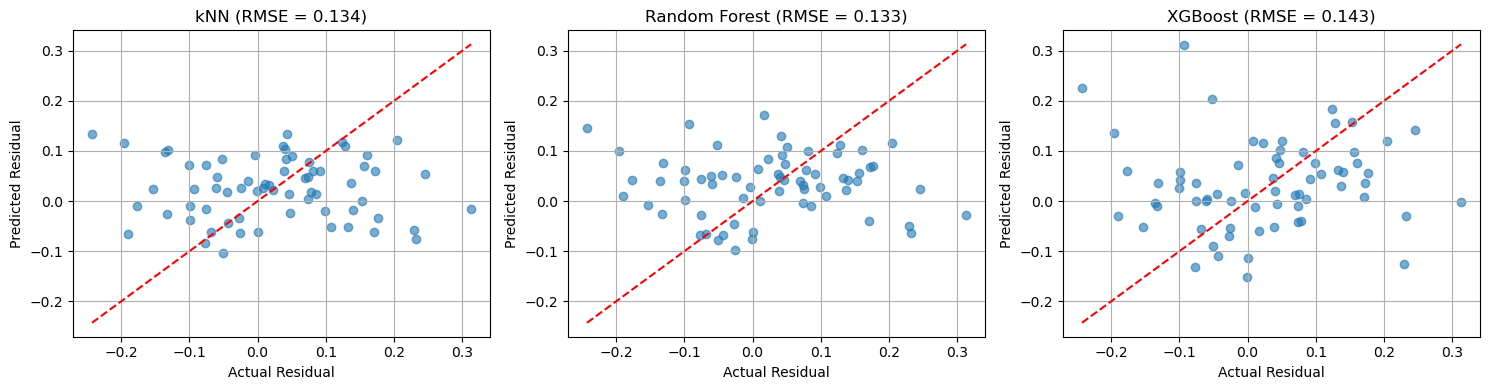

In [2]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load your FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define models ===
models = {
    "kNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# === Plot predicted vs actual ===
plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items(), 1):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    plt.subplot(1, 3, i)
    plt.scatter(y, y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Actual Residual")
    plt.ylabel("Predicted Residual")
    plt.title(f"{name} (RMSE = {rmse:.3f})")
    plt.grid(True)

plt.tight_layout()
plt.show()

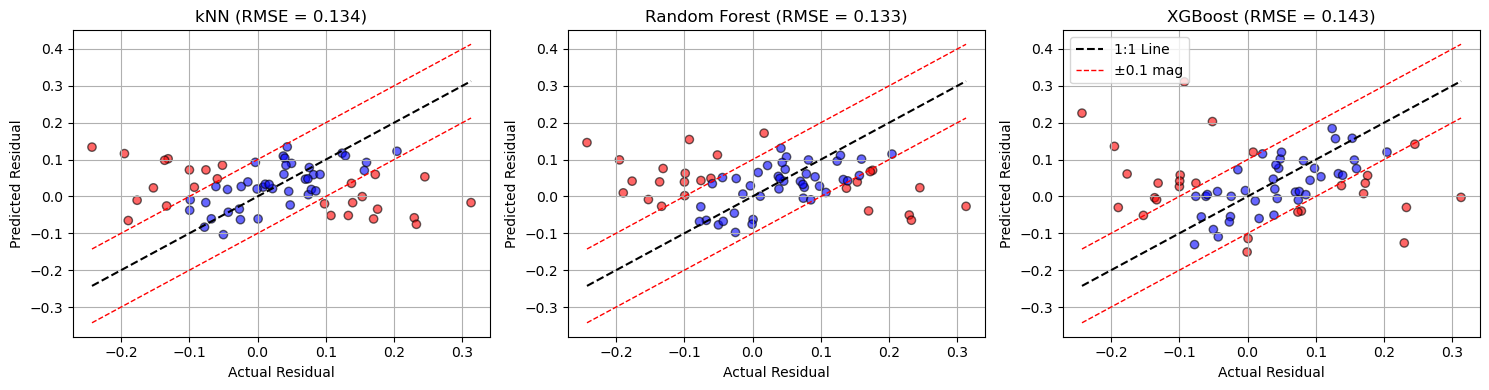

In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define models ===
models = {
    "kNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# === Plot predicted vs actual with outlier coloring ===
plt.figure(figsize=(15, 4))
outlier_thresh = 0.1  # threshold in magnitudes

for i, (name, model) in enumerate(models.items(), 1):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Color by outlier status
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    colors = np.where(is_outlier, "red", "blue")

    plt.subplot(1, 3, i)
    plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
    plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
    plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
    plt.xlabel("Actual Residual")
    plt.ylabel("Predicted Residual")
    plt.title(f"{name} (RMSE = {rmse:.3f})")
    plt.grid(True)

plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

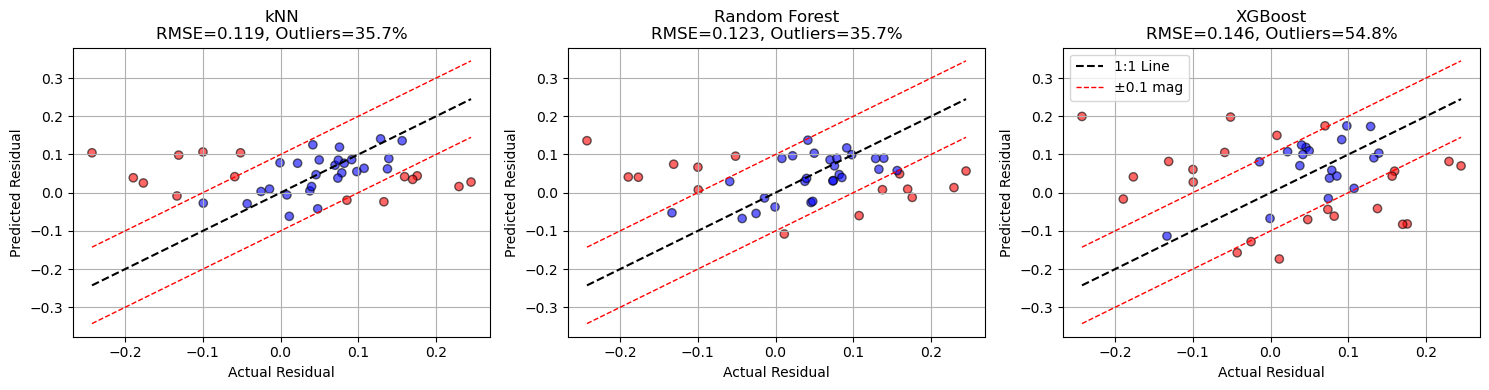


Model Performance Summary:
           Model    RMSE     MAE      R²  Outlier % (>0.1 mag)
0            kNN  0.1188  0.0874 -0.1599               35.7143
1  Random Forest  0.1234  0.0936 -0.2521               35.7143
2        XGBoost  0.1464  0.1217 -0.7624               54.7619


In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select all useful features ===
selected_features = [
    "COLOR_G-R", "DN4000", "SFR", "VDISP", "LOGMSTAR",
    "ABSMAG01_SDSS_G", "ABSMAG01_SDSS_R", "LOGSSFR", "MSTAR"
]

df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define models ===
models = {
    "kNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# === Stats + Plotting ===
plt.figure(figsize=(15, 4))
outlier_thresh = 0.1
stats_summary = []

for i, (name, model) in enumerate(models.items(), 1):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=5)

    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    outlier_pct = 100 * np.mean(np.abs(y - y_pred) > outlier_thresh)

    stats_summary.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Outlier % (>0.1 mag)": outlier_pct
    })

    is_outlier = np.abs(y - y_pred) > outlier_thresh
    colors = np.where(is_outlier, "red", "blue")

    plt.subplot(1, 3, i)
    plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
    plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
    plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
    plt.xlabel("Actual Residual")
    plt.ylabel("Predicted Residual")
    plt.title(f"{name}\nRMSE={rmse:.3f}, Outliers={outlier_pct:.1f}%")
    plt.grid(True)

plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

# === Print Stats Table ===
results_df = pd.DataFrame(stats_summary)
print("\nModel Performance Summary:")
print(results_df.round(4))

In [6]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select all useful features ===
selected_features = [
    "COLOR_G-R", "DN4000", "SFR", "VDISP", "LOGMSTAR",
    "ABSMAG01_SDSS_G", "ABSMAG01_SDSS_R", "LOGSSFR", "MSTAR"
]

df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Pipeline + Fit ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline.fit(X, y)

# === Permutation Importance ===
result = permutation_importance(
    pipeline, X, y,
    n_repeats=30,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

# === Format results ===
importances_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance (ΔRMSE)": result.importances_mean,
    "Std Dev": result.importances_std
}).sort_values("Importance (ΔRMSE)", ascending=False)

# === Display or print ===
print("\nPermutation-Based Feature Importances:")
print(importances_df.to_string(index=False))


Permutation-Based Feature Importances:
        Feature  Importance (ΔRMSE)  Std Dev
      COLOR_G-R            0.054451 0.008842
        LOGSSFR            0.025437 0.006255
          VDISP            0.016433 0.003497
            SFR            0.013888 0.003067
ABSMAG01_SDSS_G            0.012813 0.002033
         DN4000            0.012029 0.001563
       LOGMSTAR            0.009622 0.001649
ABSMAG01_SDSS_R            0.008716 0.001360
          MSTAR            0.005926 0.000644


Model: Random Forest (Top 3 Features)
RMSE: 0.1165
MAE:  0.0893
R²:   -0.1171
Outlier % (>0.1 mag): 30.95%


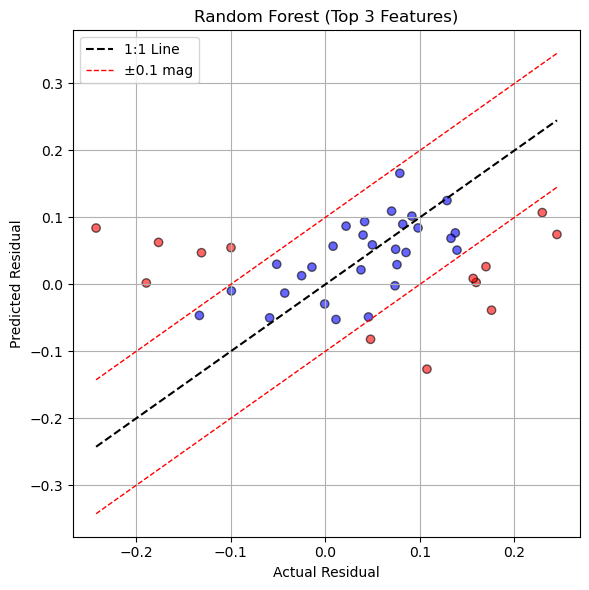

In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select top 3 features based on permutation importance ===
top_features = ["COLOR_G-R", "LOGSSFR", "VDISP"]

# Drop rows with missing values in selected features or target
df_clean = df.dropna(subset=top_features + ["RESIDUAL"])
X = df_clean[top_features]
y = df_clean["RESIDUAL"]

# === Define and evaluate Random Forest ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=5)

# === Compute metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
outlier_thresh = 0.1
outlier_pct = 100 * np.mean(np.abs(y - y_pred) > outlier_thresh)

# === Print results ===
print("Model: Random Forest (Top 3 Features)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Outlier % (>0.1 mag): {outlier_pct:.2f}%")

# === Plot predicted vs actual ===
plt.figure(figsize=(6, 6))
is_outlier = np.abs(y - y_pred) > outlier_thresh
colors = np.where(is_outlier, "red", "blue")

plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title("Random Forest (Top 3 Features)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# kNN Isolated #

Number of samples after cleaning: 67
RMSE: 0.1342
Outlier rate (> ±0.1 mag): 38.81%
NMAD: 0.1052


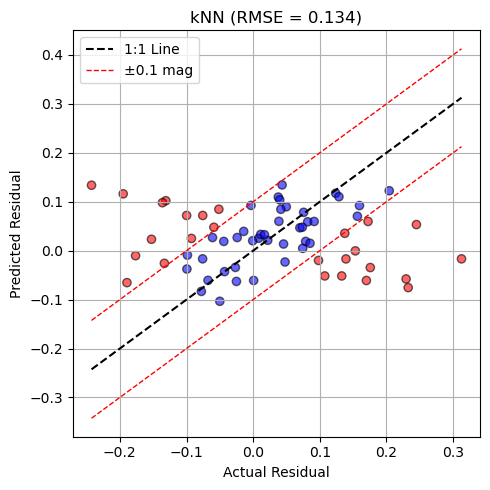

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

print(f"Number of samples after cleaning: {len(df_clean)}")

# === Define kNN model ===
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", KNeighborsRegressor(n_neighbors=5))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.1  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"kNN (RMSE = {rmse:.3f})")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

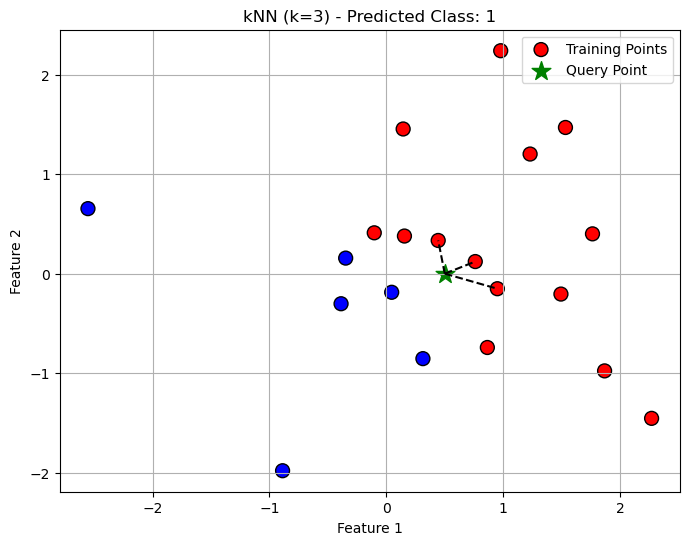

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# === Make simple fake data ===
np.random.seed(0)
X = np.random.randn(20, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(int)  # simple rule: sum of coordinates > 0

# === Train kNN ===
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)

# === New query point ===
query = np.array([[0.5, 0]])

# === Predict for query ===
predicted_class = knn.predict(query)[0]
distances, indices = knn.kneighbors(query)

# === Plot everything ===
plt.figure(figsize=(8, 6))
colors = ['blue' if label == 0 else 'red' for label in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', s=100, label="Training Points")
plt.scatter(query[:, 0], query[:, 1], c='green', marker='*', s=200, label="Query Point")

# Highlight k nearest neighbors
for idx in indices[0]:
    plt.plot([query[0, 0], X[idx, 0]], [query[0, 1], X[idx, 1]], 'k--')

plt.legend()
plt.title(f"kNN (k={k}) - Predicted Class: {predicted_class}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

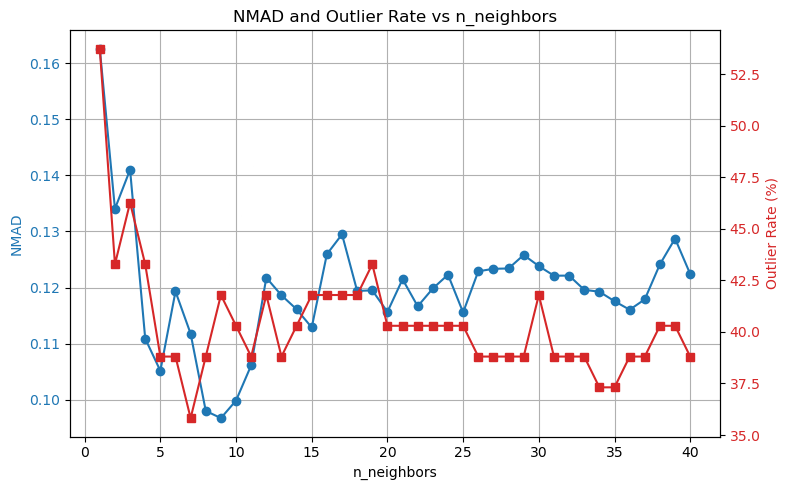

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Loop over different n_neighbors ===
n_neighbors_list = np.linspace(1, 40, 40, dtype=int)
nmad_list = []
outlier_rate_list = []

for n_neighbors in n_neighbors_list:
    # Define the model
    knn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor(n_neighbors=n_neighbors))
    ])
    
    # Cross-validation prediction
    y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)
    
    # Calculate NMAD and Outlier Rate
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    # Store results
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Plot NMAD and Outlier Rate vs n_neighbors ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('n_neighbors')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(n_neighbors_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(n_neighbors_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('NMAD and Outlier Rate vs n_neighbors')
fig.tight_layout()
plt.show()

RMSE: 0.1287
Outlier rate (> ±0.3 mag): 4.48%
NMAD: 0.1118


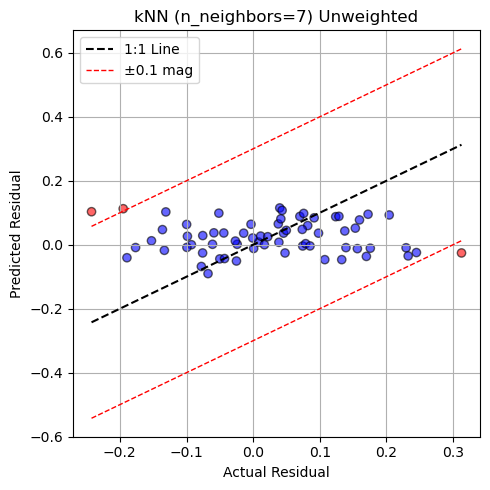

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define kNN model (NOW WITH 7 NEIGHBORS) ===
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", KNeighborsRegressor(n_neighbors=7))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.3  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"kNN (n_neighbors=7) Unweighted")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

RMSE: 0.1235
Outlier rate (> ±0.1 mag): 41.79%
NMAD: 0.0968


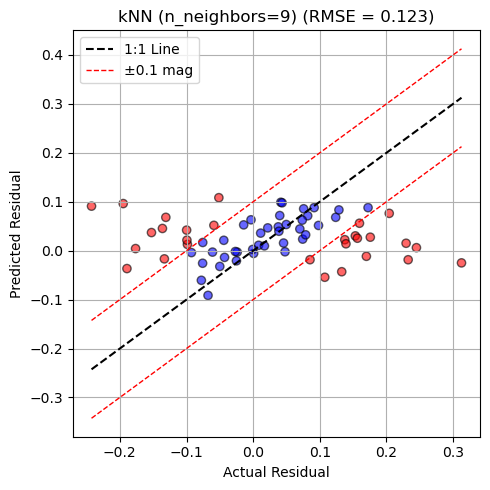

In [13]:
# === Define kNN model (NOW WITH 9 NEIGHBORS) ===
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", KNeighborsRegressor(n_neighbors=9))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.1  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"kNN (n_neighbors=9) (RMSE = {rmse:.3f})")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

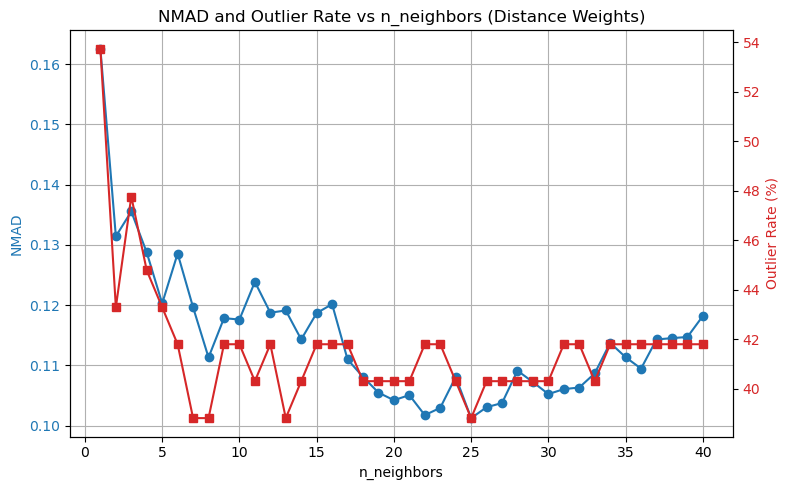

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Loop over different n_neighbors ===
n_neighbors_list = np.linspace(1, 40, 40, dtype=int)
nmad_list = []
outlier_rate_list = []

for n_neighbors in n_neighbors_list:
    # Define the model with DISTANCE WEIGHTS
    knn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance'))
    ])
    
    # Cross-validation prediction
    y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)
    
    # Calculate NMAD and Outlier Rate
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    # Store results
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Plot NMAD and Outlier Rate vs n_neighbors ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('n_neighbors')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(n_neighbors_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(n_neighbors_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('NMAD and Outlier Rate vs n_neighbors (Distance Weights)')
fig.tight_layout()
plt.show()

RMSE: 0.1213
Outlier rate (> ±0.3 mag): 2.99%
NMAD: 0.1012


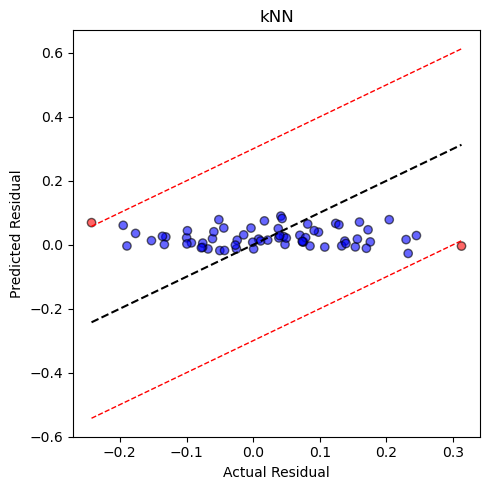

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define kNN model (25 neighbors, DISTANCE weights) ===
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", KNeighborsRegressor(n_neighbors=25, weights='distance'))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(knn_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.3  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"kNN")
plt.tight_layout()
plt.show()


# Random Forest #

RMSE: 0.1332
Outlier rate (> ±0.1 mag): 37.31%
NMAD: 0.1291


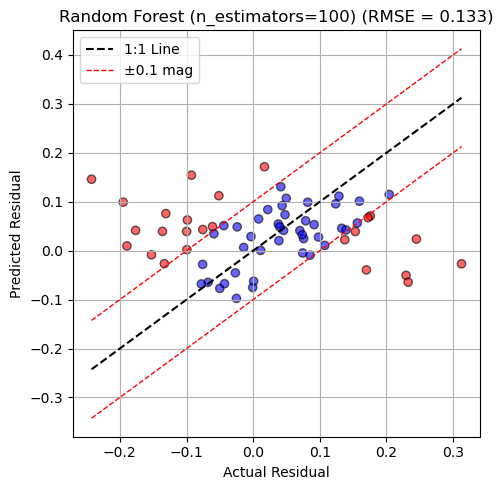

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # <-- CHANGED HERE
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define Random Forest model ===
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # technically not needed for RF, but harmless
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(rf_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.1  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"Random Forest (n_estimators=100) (RMSE = {rmse:.3f})")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


Feature importances:
DN4000: 0.4178
COLOR_G-R: 0.3515
SFR: 0.2307


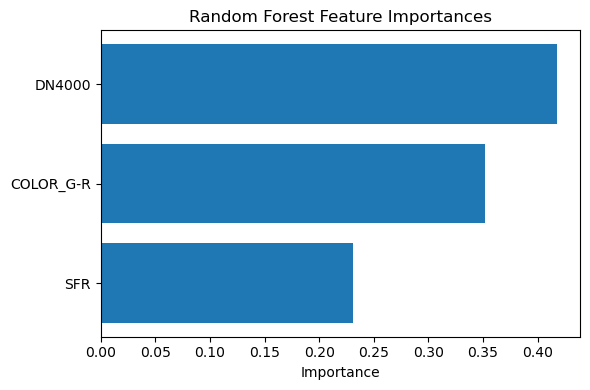

In [19]:
# === After you finish cross_val_predict and plot ===

# Refit the Random Forest model on the whole dataset (no CV) to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = selected_features

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# === Print feature importances ===
print("\nFeature importances:")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# === Optional: plot feature importances ===
plt.figure(figsize=(6, 4))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Best NMAD achieved at n_estimators = 142 with NMAD = 0.1187
Best Outlier Rate achieved at n_estimators = 409 with Outlier Rate = 35.82%


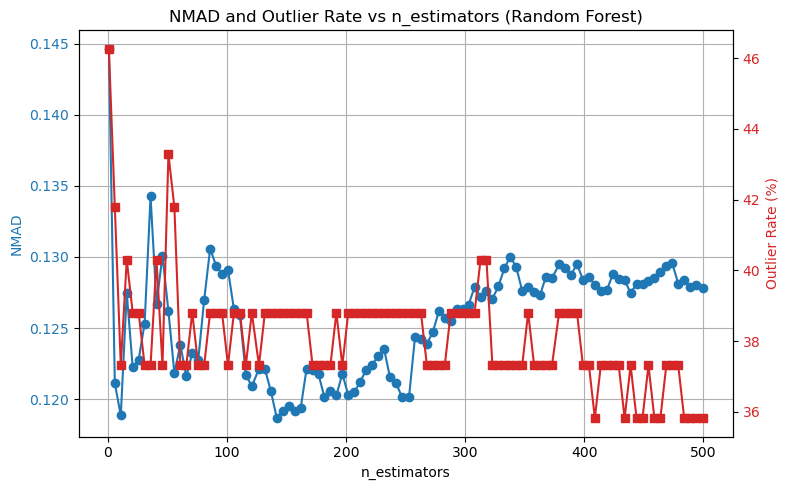

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Set up list of n_estimators to try ===
n_estimators_list = np.linspace(1, 500, 100, dtype=int)
nmad_list = []
outlier_rate_list = []

# === Loop over n_estimators ===
for n_estimators in n_estimators_list:
    rf_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor(n_estimators=n_estimators, random_state=42))
    ])
    
    y_pred = cross_val_predict(rf_pipeline, X, y, cv=5)
    
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Find best n_estimators ===
nmad_array = np.array(nmad_list)
outlier_array = np.array(outlier_rate_list)

best_nmad_idx = np.argmin(nmad_array)
best_outlier_idx = np.argmin(outlier_array)

print(f"Best NMAD achieved at n_estimators = {n_estimators_list[best_nmad_idx]} with NMAD = {nmad_array[best_nmad_idx]:.4f}")
print(f"Best Outlier Rate achieved at n_estimators = {n_estimators_list[best_outlier_idx]} with Outlier Rate = {outlier_array[best_outlier_idx]:.2f}%")

# === Plot NMAD and Outlier Rate vs n_estimators ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(n_estimators_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(n_estimators_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('NMAD and Outlier Rate vs n_estimators (Random Forest)')
fig.tight_layout()
plt.show()

Best NMAD achieved at max_depth = 1 with NMAD = 0.0988
Best Outlier Rate achieved at max_depth = 11 with Outlier Rate = 38.81%


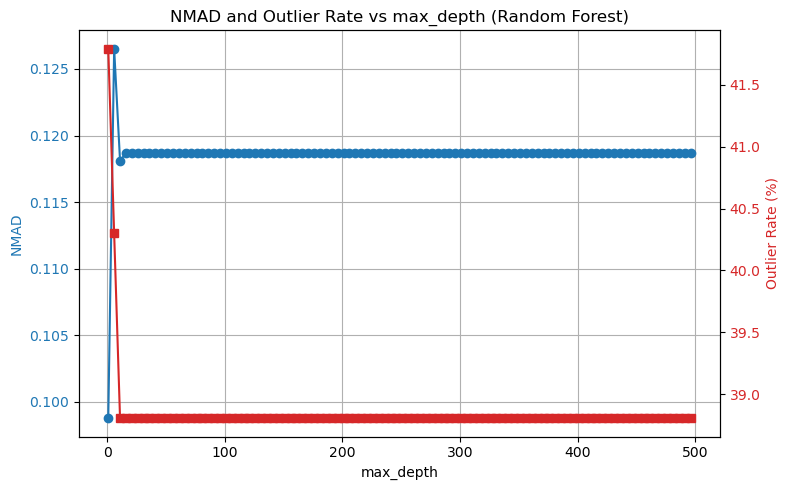

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Set up list of max_depths to try ===
max_depth_list = np.arange(1, 500, 5)
nmad_list = []
outlier_rate_list = []

# === Loop over max_depths ===
for max_depth in max_depth_list:
    rf_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor(n_estimators=142, max_depth=max_depth, random_state=42))
    ])
    
    y_pred = cross_val_predict(rf_pipeline, X, y, cv=5)
    
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Find best max_depth ===
nmad_array = np.array(nmad_list)
outlier_array = np.array(outlier_rate_list)

best_nmad_idx = np.argmin(nmad_array)
best_outlier_idx = np.argmin(outlier_array)

print(f"Best NMAD achieved at max_depth = {max_depth_list[best_nmad_idx]} with NMAD = {nmad_array[best_nmad_idx]:.4f}")
print(f"Best Outlier Rate achieved at max_depth = {max_depth_list[best_outlier_idx]} with Outlier Rate = {outlier_array[best_outlier_idx]:.2f}%")

# === Plot NMAD and Outlier Rate vs max_depth ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('max_depth')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(max_depth_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(max_depth_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('NMAD and Outlier Rate vs max_depth (Random Forest)')
fig.tight_layout()
plt.show()

RMSE: 0.1338
Outlier rate (> ±0.3 mag): 4.48%
NMAD: 0.1187


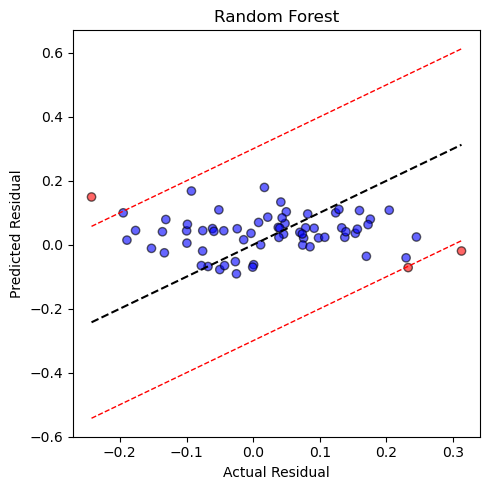

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # <-- CHANGED HERE
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define Random Forest model ===
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # technically not needed for RF, but harmless
    ("regressor", RandomForestRegressor(n_estimators=142, random_state=42))  # <-- CHANGED HERE 
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(rf_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))

outlier_thresh = 0.3  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"Random Forest")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__n_estimators=300; total time=   0.1s
[CV] END regressor__max_depth=5, regressor__max_features=sqrt, regressor__min_samples

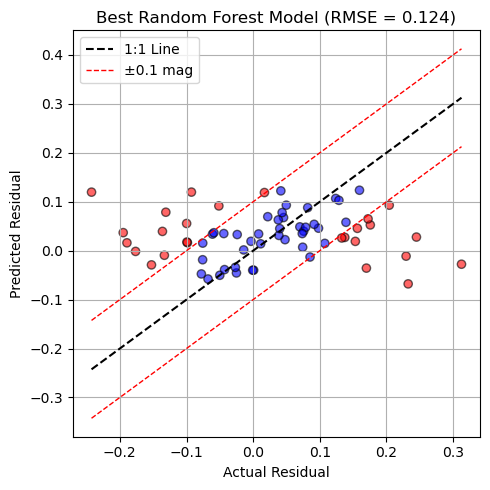

In [33]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and target ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define a basic pipeline ===
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(random_state=42))
])

# === Define the grid of hyperparameters ===
param_grid = {
    "regressor__n_estimators": [100, 300, 500],
    "regressor__max_depth": [5, 10, 20, None],
    "regressor__min_samples_leaf": [1, 2, 5],
    "regressor__max_features": ["sqrt", "log2", None]
}

# === Set up GridSearchCV ===
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='neg_median_absolute_error',  # because we care about median errors (NMAD-like behavior)
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all cores to speed up
)

# === Run the grid search ===
grid_search.fit(X, y)

# === Print the best parameters ===
print("\nBest Parameters Found:")
print(grid_search.best_params_)

# === Best model performance ===
print(f"Best Median Absolute Error: {-grid_search.best_score_:.4f}")

# === Now evaluate the best model on cross-validation ===
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=5)

rmse = np.sqrt(mean_squared_error(y, y_pred))
outlier_thresh = 0.1
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)
nmad = 1.4826 * np.median(np.abs(y_pred - y))

print(f"\nFinal Cross-Validation Metrics with Best Model:")
print(f"RMSE: {rmse:.4f}")
print(f"NMAD: {nmad:.4f}")
print(f"Outlier Rate (> ±0.1 mag): {outlier_rate:.2f}%")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"Best Random Forest Model (RMSE = {rmse:.3f})")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# XGBOOST #

RMSE: 0.1458
Outlier rate (> ±0.3 mag): 4.48%
NMAD: 0.1216


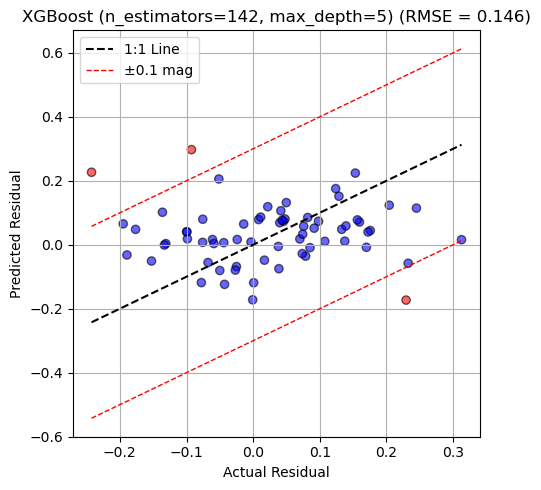

In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor  # <-- NEW IMPORT
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define XGBoost model ===
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # scaling optional for XGB, harmless to leave it
    ("regressor", XGBRegressor(
        n_estimators=142,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
outlier_thresh = 0.3  # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)
nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"RMSE: {rmse:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")
print(f"NMAD: {nmad:.4f}")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"XGBoost (n_estimators=142, max_depth=5) (RMSE = {rmse:.3f})")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

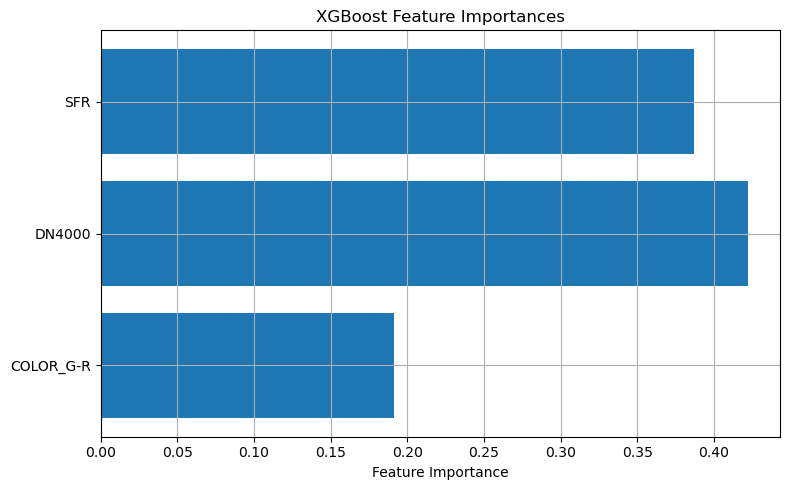

In [7]:
# === After fitting the model once ===
# Let's fit it once to the whole data so we can visualize feature importances

# 1. Fit on all data
xgb_pipeline.fit(X, y)

# 2. Access the trained XGBRegressor inside the pipeline
xgb_model = xgb_pipeline.named_steps["regressor"]

# 3. Plot feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import numpy as np
import pandas as pd

# Train simple tree
X = pd.DataFrame({
    "COLOR_G-R": [0.3, 0.5, 0.7, 0.2],
    "DN4000": [1.2, 1.4, 1.6, 1.1],
    "SFR": [0.05, 0.02, 0.01, 0.2]
})
y = [0.1, 0.2, 0.3, 0.05]
regressor = DecisionTreeRegressor(max_depth=2)
regressor.fit(X, y)

# New data point
sample = X.iloc[[0]]

# Walk through decisions
node_indicator = regressor.decision_path(sample)
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold

for node_id in node_indicator.indices:
    if feature[node_id] != -2:  # -2 is a leaf
        fname = X.columns[feature[node_id]]
        if sample.iloc[0, feature[node_id]] <= threshold[node_id]:
            decision = f"{fname} <= {threshold[node_id]:.2f}"
        else:
            decision = f"{fname} > {threshold[node_id]:.2f}"
        print(f"Node {node_id}: {decision}")

Node 0: COLOR_G-R <= 0.40
Node 1: SFR <= 0.13


In [10]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import graphviz
import numpy as np
import pandas as pd

# === Step 1: Create and train the tree ===
X = pd.DataFrame({
    "COLOR_G-R": [0.3, 0.5, 0.7, 0.2],
    "DN4000": [1.2, 1.4, 1.6, 1.1],
    "SFR": [0.05, 0.02, 0.01, 0.2]
})
y = [0.1, 0.2, 0.3, 0.05]
regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
regressor.fit(X, y)

# === Step 2: Pick a sample ===
sample = X.iloc[[0]]  # e.g., first sample

# === Step 3: Find decision path ===
node_indicator = regressor.decision_path(sample)
path_nodes = node_indicator.indices

# === Step 4: Export the tree with highlighted path ===
dot_data = export_graphviz(
    regressor,
    out_file=None,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
    node_ids=True  # important: export node IDs
)

# === Step 5: Modify dot file to highlight path nodes ===
# Parse the dot data
dot_lines = dot_data.splitlines()
new_dot_lines = []
for line in dot_lines:
    if "label=" in line:
        # Find the node id
        node_id = int(line.strip().split()[0])
        if node_id in path_nodes:
            # Highlight path nodes
            line = line.replace('filled', 'style=filled, fillcolor=lightblue')
    new_dot_lines.append(line)

# Join the modified dot lines
highlighted_dot_data = "\n".join(new_dot_lines)

# === Step 6: Visualize the highlighted tree ===
graph = graphviz.Source(highlighted_dot_data)
graph.render("highlighted_tree", view=True, format="pdf")  # Saves and opens a PDF

'highlighted_tree.pdf'

Best NMAD achieved at n_estimators = 11 with NMAD = 0.1078
Best Outlier Rate achieved at n_estimators = 11 with Outlier Rate = 34.33%


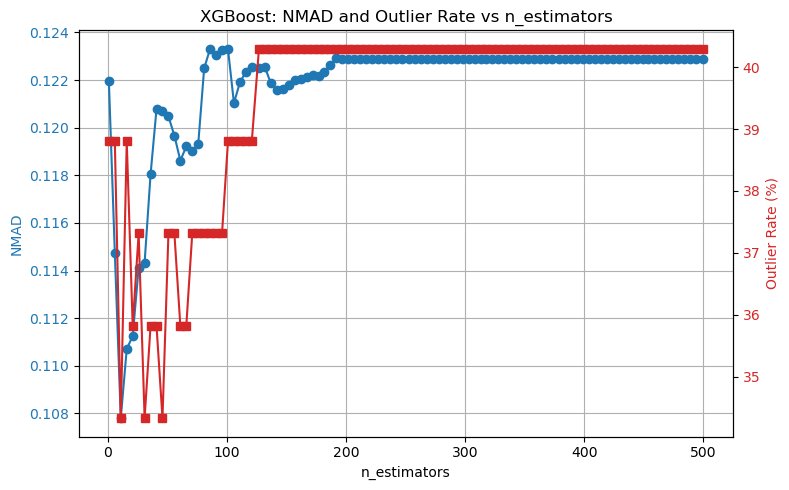

In [39]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Set up list of n_estimators to try ===
n_estimators_list = np.linspace(1, 500, 100, dtype=int)  # 100 points from 1 to 500
nmad_list = []
outlier_rate_list = []

# === Loop over n_estimators ===
for n_estimators in n_estimators_list:
    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", XGBRegressor(
            n_estimators=n_estimators,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            verbosity=0,
            n_jobs=-1
        ))
    ])
    
    y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)
    
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Find best n_estimators ===
nmad_array = np.array(nmad_list)
outlier_array = np.array(outlier_rate_list)

best_nmad_idx = np.argmin(nmad_array)
best_outlier_idx = np.argmin(outlier_array)

print(f"Best NMAD achieved at n_estimators = {n_estimators_list[best_nmad_idx]} with NMAD = {nmad_array[best_nmad_idx]:.4f}")
print(f"Best Outlier Rate achieved at n_estimators = {n_estimators_list[best_outlier_idx]} with Outlier Rate = {outlier_array[best_outlier_idx]:.2f}%")

# === Plot NMAD and Outlier Rate vs n_estimators ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(n_estimators_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(n_estimators_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('XGBoost: NMAD and Outlier Rate vs n_estimators')
fig.tight_layout()
plt.show()

Best NMAD achieved at max_depth = 1 with NMAD = 0.1105
Best Outlier Rate achieved at max_depth = 13 with Outlier Rate = 35.82%


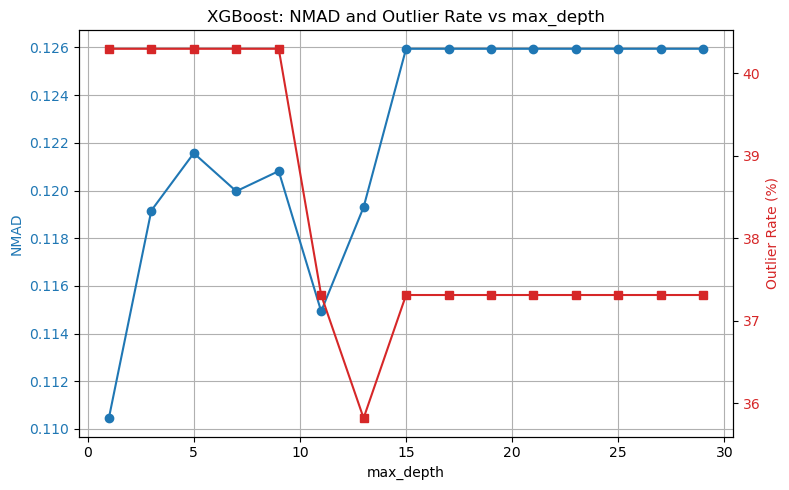

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Set up list of max_depths to try ===
max_depth_list = np.arange(1, 31, 2)  # [1, 3, 5, ..., 29]
nmad_list = []
outlier_rate_list = []

# === Loop over max_depths ===
for max_depth in max_depth_list:
    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", XGBRegressor(
            n_estimators=142,  # fix number of trees
            max_depth=max_depth,
            learning_rate=0.1,
            random_state=42,
            verbosity=0,
            n_jobs=-1
        ))
    ])
    
    y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)
    
    nmad = 1.4826 * np.median(np.abs(y_pred - y))
    outlier_thresh = 0.1
    is_outlier = np.abs(y - y_pred) > outlier_thresh
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    
    nmad_list.append(nmad)
    outlier_rate_list.append(outlier_rate)

# === Find best max_depth ===
nmad_array = np.array(nmad_list)
outlier_array = np.array(outlier_rate_list)

best_nmad_idx = np.argmin(nmad_array)
best_outlier_idx = np.argmin(outlier_array)

print(f"Best NMAD achieved at max_depth = {max_depth_list[best_nmad_idx]} with NMAD = {nmad_array[best_nmad_idx]:.4f}")
print(f"Best Outlier Rate achieved at max_depth = {max_depth_list[best_outlier_idx]} with Outlier Rate = {outlier_array[best_outlier_idx]:.2f}%")

# === Plot NMAD and Outlier Rate vs max_depth ===
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('max_depth')
ax1.set_ylabel('NMAD', color=color)
ax1.plot(max_depth_list, nmad_list, marker='o', color=color, label='NMAD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Outlier Rate (%)', color=color)
ax2.plot(max_depth_list, outlier_rate_list, marker='s', color=color, label='Outlier Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('XGBoost: NMAD and Outlier Rate vs max_depth')
fig.tight_layout()
plt.show()

Performance with n_estimators=11, max_depth=13
RMSE: 0.1255
NMAD: 0.1043
Outlier rate (> ±0.3 mag): 4.48%


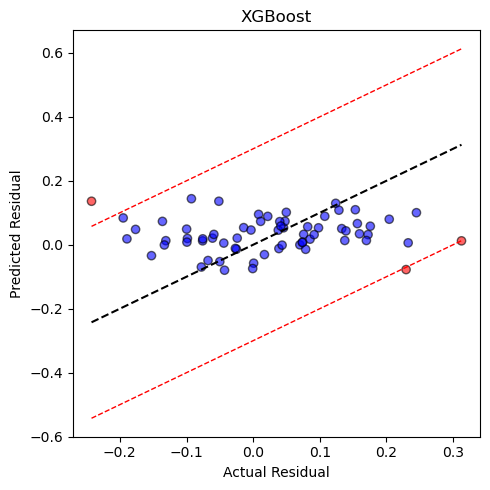

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define XGBoost model with your parameters ===
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", XGBRegressor(
        n_estimators=11,
        max_depth=13,
        learning_rate=0.1,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
outlier_thresh = 0.3 # threshold in magnitudes
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)
nmad = 1.4826 * np.median(np.abs(y_pred - y))

# === Print metrics ===
print(f"Performance with n_estimators=11, max_depth=13")
print(f"RMSE: {rmse:.4f}")
print(f"NMAD: {nmad:.4f}")
print(f"Outlier rate (> ±{outlier_thresh} mag): {outlier_rate:.2f}%")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"XGBoost")
plt.tight_layout()
plt.show()


Model Performance using ['COLOR-G-R', 'DN4000', 'SFR']:
RMSE: 0.1458
NMAD: 0.1216
Explained Variance (R²): -0.5451
Outlier Rate (> ±0.1 mag): 40.30%


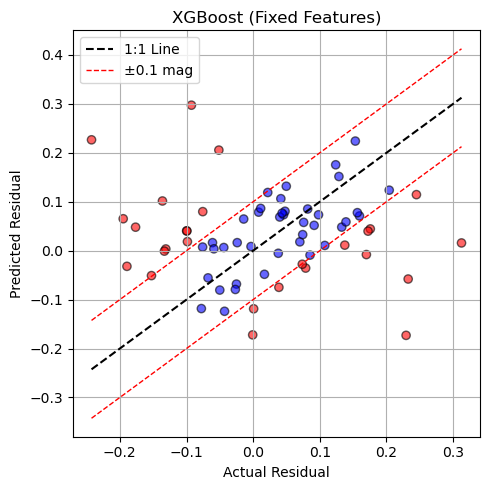

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Use predetermined features ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define XGBoost model ===
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", XGBRegressor(
        n_estimators=142,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ))
])

# === Cross-validation prediction ===
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
nmad = 1.4826 * np.median(np.abs(y_pred - y))
explained_variance = r2_score(y, y_pred)
outlier_thresh = 0.1
is_outlier = np.abs(y - y_pred) > outlier_thresh
outlier_rate = 100 * np.sum(is_outlier) / len(y)

# === Print metrics ===
print(f"\nModel Performance using ['COLOR-G-R', 'DN4000', 'SFR']:")
print(f"RMSE: {rmse:.4f}")
print(f"NMAD: {nmad:.4f}")
print(f"Explained Variance (R²): {explained_variance:.4f}")
print(f"Outlier Rate (> ±0.1 mag): {outlier_rate:.2f}%")

# === Plot predicted vs actual ===
colors = np.where(is_outlier, "red", "blue")

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, c=colors, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label="1:1 Line")
plt.plot([y.min(), y.max()], [y.min() + outlier_thresh, y.max() + outlier_thresh], 'r--', lw=1, label="±0.1 mag")
plt.plot([y.min(), y.max()], [y.min() - outlier_thresh, y.max() - outlier_thresh], 'r--', lw=1)
plt.xlabel("Actual Residual")
plt.ylabel("Predicted Residual")
plt.title(f"XGBoost (Fixed Features)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=1.0; total time=   0.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=50, regressor__subsample=1.0

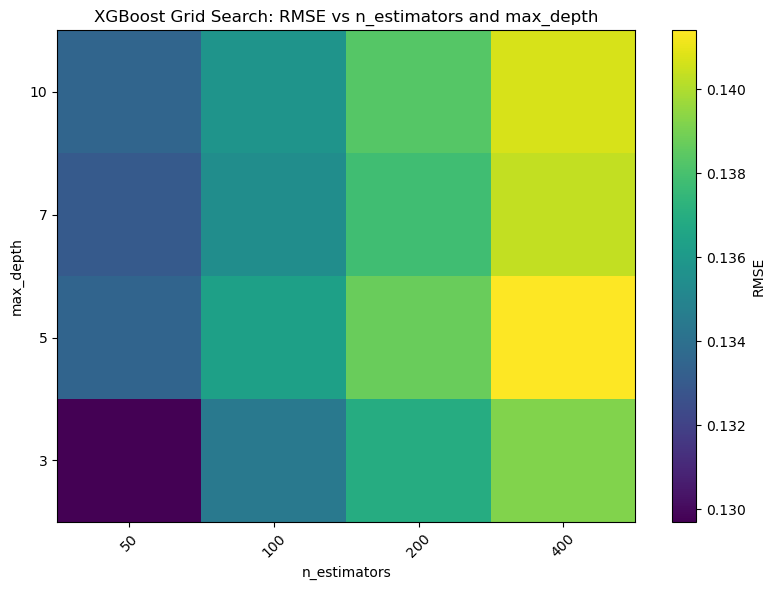

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from astropy.table import Table
import pandas as pd
import numpy as np

# === Load Data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Set up pipeline ===
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", XGBRegressor(random_state=42, verbosity=0, n_jobs=-1))
])

# === Define parameter grid ===
param_grid = {
    "regressor__n_estimators": [50, 100, 200, 400],
    "regressor__max_depth": [3, 5, 7, 10],
    "regressor__learning_rate": [0.01, 0.1, 0.2],
    "regressor__subsample": [0.8, 1.0],
}

# === Set up GridSearch ===
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    n_jobs=-1
)

# === Fit Grid Search ===
grid_search.fit(X, y)

# === Best Model Info ===
print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === After you run grid_search.fit(X, y) ===
cv_results = pd.DataFrame(grid_search.cv_results_)

# === Focus on n_estimators vs max_depth ===
pivot_table = cv_results.pivot_table(
    index="param_regressor__max_depth",
    columns="param_regressor__n_estimators",
    values="mean_test_score"
)

# === Because scores are negative MSE, convert to RMSE ===
pivot_table = np.sqrt(-pivot_table)

# === Plot heatmap ===
plt.figure(figsize=(8,6))
plt.title("XGBoost Grid Search: RMSE vs n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.imshow(pivot_table, origin='lower', aspect='auto', cmap="viridis")
plt.colorbar(label="RMSE")
plt.xticks(np.arange(len(pivot_table.columns)), pivot_table.columns, rotation=45)
plt.yticks(np.arange(len(pivot_table.index)), pivot_table.index)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END regressor__learning_rate=0.1366666666666667, regressor__max_depth=6, regressor__n_estimators=300, regressor__subsample=0.6888888888888889; total time=   0.0s
[CV] END regressor__learning_rate=0.09444444444444444, regressor__max_depth=14, regressor__n_estimators=450, regressor__subsample=0.7777777777777778; total time=   0.0s
[CV] END regressor__learning_rate=0.1366666666666667, regressor__max_depth=6, regressor__n_estimators=300, regressor__subsample=0.6888888888888889; total time=   0.0s
[CV] END regressor__learning_rate=0.1366666666666667, regressor__max_depth=6, regressor__n_estimators=300, regressor__subsample=0.6888888888888889; total time=   0.0s
[CV] END regressor__learning_rate=0.03111111111111111, regressor__max_depth=16, regressor__n_estimators=200, regressor__subsample=0.6444444444444444; total time=   0.0s
[CV] END regressor__learning_rate=0.09444444444444444, regressor__max_depth=16, regressor__n_esti

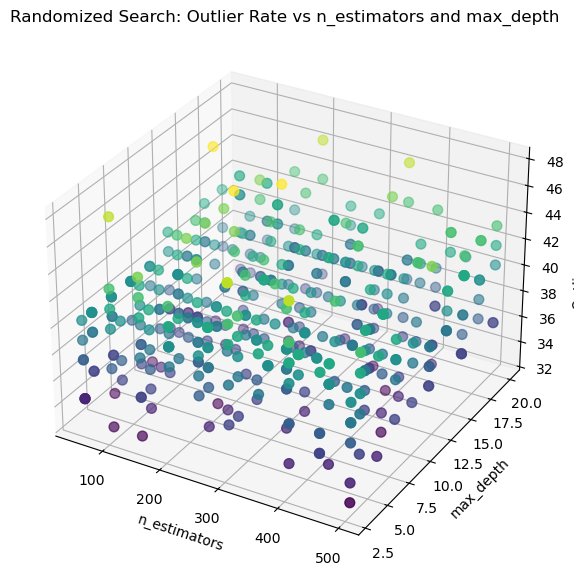

In [2]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Select features and clean ===
selected_features = ["COLOR_G-R", "DN4000", "SFR"]
df_clean = df.dropna(subset=selected_features + ["RESIDUAL"])
X = df_clean[selected_features]
y = df_clean["RESIDUAL"]

# === Define parameter grid ===
param_grid = {
    "regressor__n_estimators": np.linspace(50, 500, 10, dtype=int),    # 10 values
    "regressor__max_depth": np.linspace(3, 20, 10, dtype=int),          # 10 values
    "regressor__learning_rate": np.linspace(0.01, 0.2, 10),            # 10 values
    "regressor__subsample": np.linspace(0.6, 1.0, 10),                 # 10 values
}

# === Define model pipeline ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", XGBRegressor(random_state=42, verbosity=0, n_jobs=-1))
])

# === RandomizedSearchCV Setup ===
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=500,            # Sample 500 random combinations
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === Run Randomized Search ===
search.fit(X, y)

# === Get Results ===
results = pd.DataFrame(search.cv_results_)

# === Calculate Outlier Rate Manually ===
outlier_rates = []
for i in range(len(results)):
    best_params = results.iloc[i]['params']
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", XGBRegressor(
            n_estimators=best_params['regressor__n_estimators'],
            max_depth=best_params['regressor__max_depth'],
            learning_rate=best_params['regressor__learning_rate'],
            subsample=best_params['regressor__subsample'],
            random_state=42,
            verbosity=0,
            n_jobs=-1
        ))
    ])
    y_pred = cross_val_predict(model, X, y, cv=5)
    is_outlier = np.abs(y - y_pred) > 0.1
    outlier_rate = 100 * np.sum(is_outlier) / len(y)
    outlier_rates.append(outlier_rate)

results['outlier_rate'] = outlier_rates

# === 3D Plotting ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    results["param_regressor__n_estimators"],
    results["param_regressor__max_depth"],
    results["outlier_rate"],
    c=results["outlier_rate"], cmap="viridis", s=50
)

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Outlier Rate (%)')
ax.set_title('Randomized Search: Outlier Rate vs n_estimators and max_depth')
plt.show()

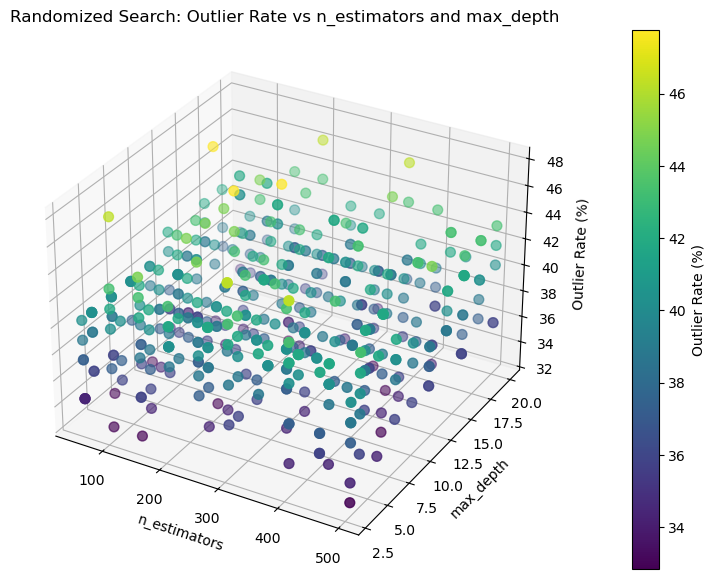

In [3]:
# === 3D Plotting with Colorbar ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Make scatter plot and capture it
sc = ax.scatter(
    results["param_regressor__n_estimators"],
    results["param_regressor__max_depth"],
    results["outlier_rate"],
    c=results["outlier_rate"], cmap="viridis", s=50
)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Outlier Rate (%)')

# Labels
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Outlier Rate (%)')
ax.set_title('Randomized Search: Outlier Rate vs n_estimators and max_depth')

plt.show()

# NMAD Baseline #

In [3]:
from astropy.table import Table
import numpy as np

# === Load FITS data ===
data = Table.read("residuals_with_targetid_vdisp_logmstar_dn4000_sfr_vdisp_absmag_g_absmag_r_logSSFR_mstar_color_g-r.fits")
df = data.to_pandas()

# === Extract residuals and clean ===
y = df["RESIDUAL"].dropna()

# === Calculate NMAD ===
nmad = 1.4826 * np.median(np.abs(y - np.median(y)))

# === Print NMAD ===
print(f"NMAD of residuals (no galaxy info): {nmad:.4f}")

NMAD of residuals (no galaxy info): 0.1168
